# Initial EDA

Source: https://www.kaggle.com/c/petfinder-adoption-prediction/data

Files:


* train.csv - Tabular/text data for the training set
* test.csv - Tabular/text data for the test set
* sample_submission.csv - A sample submission file in the correct format
* breed_labels.csv - Contains Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat.
* color_labels.csv - Contains ColorName for each ColorID
* state_labels.csv - Contains StateName for each StateID

Goal is to use the data to predict `AdoptionSpeed`.

Let's start by exploring the tabular/text data for the training set.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pandas_profiling import ProfileReport

In [2]:
SOURCE_DATA_FOLDER = "../data/source/petfinder-adoption-prediction/"

TRAIN_TABULAR = SOURCE_DATA_FOLDER + "train/train.csv"
TRAIN_IMAGE_FOLDER = SOURCE_DATA_FOLDER + "train_images/"
TRAIN_METADATA_FOLDER = SOURCE_DATA_FOLDER + "train_metadata/"
TRAIN_SENTIMENT_FOLDER = SOURCE_DATA_FOLDER + "train_sentiment/"

TEST_TABULAR = SOURCE_DATA_FOLDER + "test/test.csv"
TEST_IMAGE_FOLDER = SOURCE_DATA_FOLDER + "test_images/"
TEST_METADATA_FOLDER = SOURCE_DATA_FOLDER + "test_metadata/"
TEST_SENTIMENT_FOLDER = SOURCE_DATA_FOLDER + "test_sentiment/"

BREED_LABELS = "breed_labels.csv"
COLOUR_LABELS = "color_labels.csv"
STATE_LABELS = "state_labels.csv"

sns.set_style("darkgrid")
sns.set_context("paper")
mpl.style.use("seaborn")

In [3]:
train_tabular = pd.read_csv(TRAIN_TABULAR)
train_tabular["source"] = "train"
test_tabular = pd.read_csv(TEST_TABULAR)
test_tabular["source"] = "test"

all_data = train_tabular #pd.concat([train_tabular, test_tabular])
profile = ProfileReport(all_data, title="Pandas Profiling Report")

In [4]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
profile.to_file("../outputs/all_data_report.html")

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
all_data.to_csv("../data/interm/train_test_merged.csv")

## Notes on Preliminary EDA:

* Type: fairly equally distributed (54:45)
* Name: Not sure how useful this will be since almost all are different; we could have a look at the lengths of the names but it probably wouldn't make sense to do that. For listings with more than 1 pet, there may be typos.
* Age: Heavily skewed to lower values, but we have some outliers (pets aged 200+ months. We will need to clean this up.)
* Breed1: 39.5% are Mixed Breed
* Breed2: 71% are 0 (no label?), and 11.5% are Mixed Breed. Some dirty data here, will have to have a deeper look.
* Gender: 14.5% are gender 3, meaning they have multiple genders in the group. Correlated with Quantity (some of the non-zero quantity pet listings will be have gender 3.)
* Color1,2,3: Colours 2 and 3 have a lot more 0s.
* MaturitySize: Almost all are 2, no missing/invalid values. 
* Vaccinated: Super high correlation with Dewormed and Sterilized (i guess that makes sense lol)
* Dewormed: Super high correlation with Vaccinated and Sterilized (i guess that makes sense lol)
* Sterilized: Super high correlation with Dewormed and Vaccinated (i guess that makes sense lol)
* Health: No missing or invalid values at first glance
* Quantity: Highly skewed to 1, no zeros thankfully. We have some large quantities though lol. For example, "30 Cats For Adoption" has Quantity=20, will have to have a deeper look.
* Fee: Heavily skewed to 0, but some extremely high adoption fees, will have to have a deeper look.
* State: Labels, needs to be converted to a categorical variable for deeper insights
* RescuerID: Should be irrelevant - it's all anonymous.
* VideoAmt: 96.2% zeros, will have to have a deeper look.
* Description: 12 missing values. Could potentially use them to create a corpus and look for important terms? Although the important details in the description could be correlated with other features like "neutered" and be subject to typos. Will have to have a deeper look.
* PetID: Should be irrelevant
* PhotoAmt: only 2.3%, and may be relevant. Will have to look into the relationship between it and AdoptionSpeed

So, these columns need more work:
* Age
* Breed1 and Breed2
* Color1, Color2, Color3
* Vaccinated
* Dewormed
* Sterilized
* Quantity
* State (labels need to be converted to categorical)
* VideoAmt + PhotoAmt: Could be used out of the box, but not many data points. We could do something with image recognition?
* Description

And these columns shouldn't be used as features:
* Name
* PetID
* RescuerID


## Investigate relationships

First, prepare data:

In [7]:
# set AdoptionSpeed categories
adoption_speed_dict = {0: "0. Same Day", 
                       1: "1. 1st Week", 
                       2: "2. 1st Month", 
                       3: "3. 2-3 Mths", 
                       4: "4. Not adopted (100d)"}
# set Type categories
type_dict = {1: "Dog", 2: "Cat"}
all_data = all_data.replace({"AdoptionSpeed": adoption_speed_dict,
                            "Type": type_dict})

# set categorical columns
# categorical_columns = ["Type", "Breed1", "Breed2", "Gender", "MaturitySize", "Vaccinated", "Dewormed", "Sterilized", "Health","Color1", "Color2", "Color3", "State", "FurLength","AdoptionSpeed"]
categorical_columns = ["AdoptionSpeed"]
for col in categorical_columns:
    all_data[col] = all_data[col].astype("category")

all_data["NameLength"] = all_data["Name"].str.len()

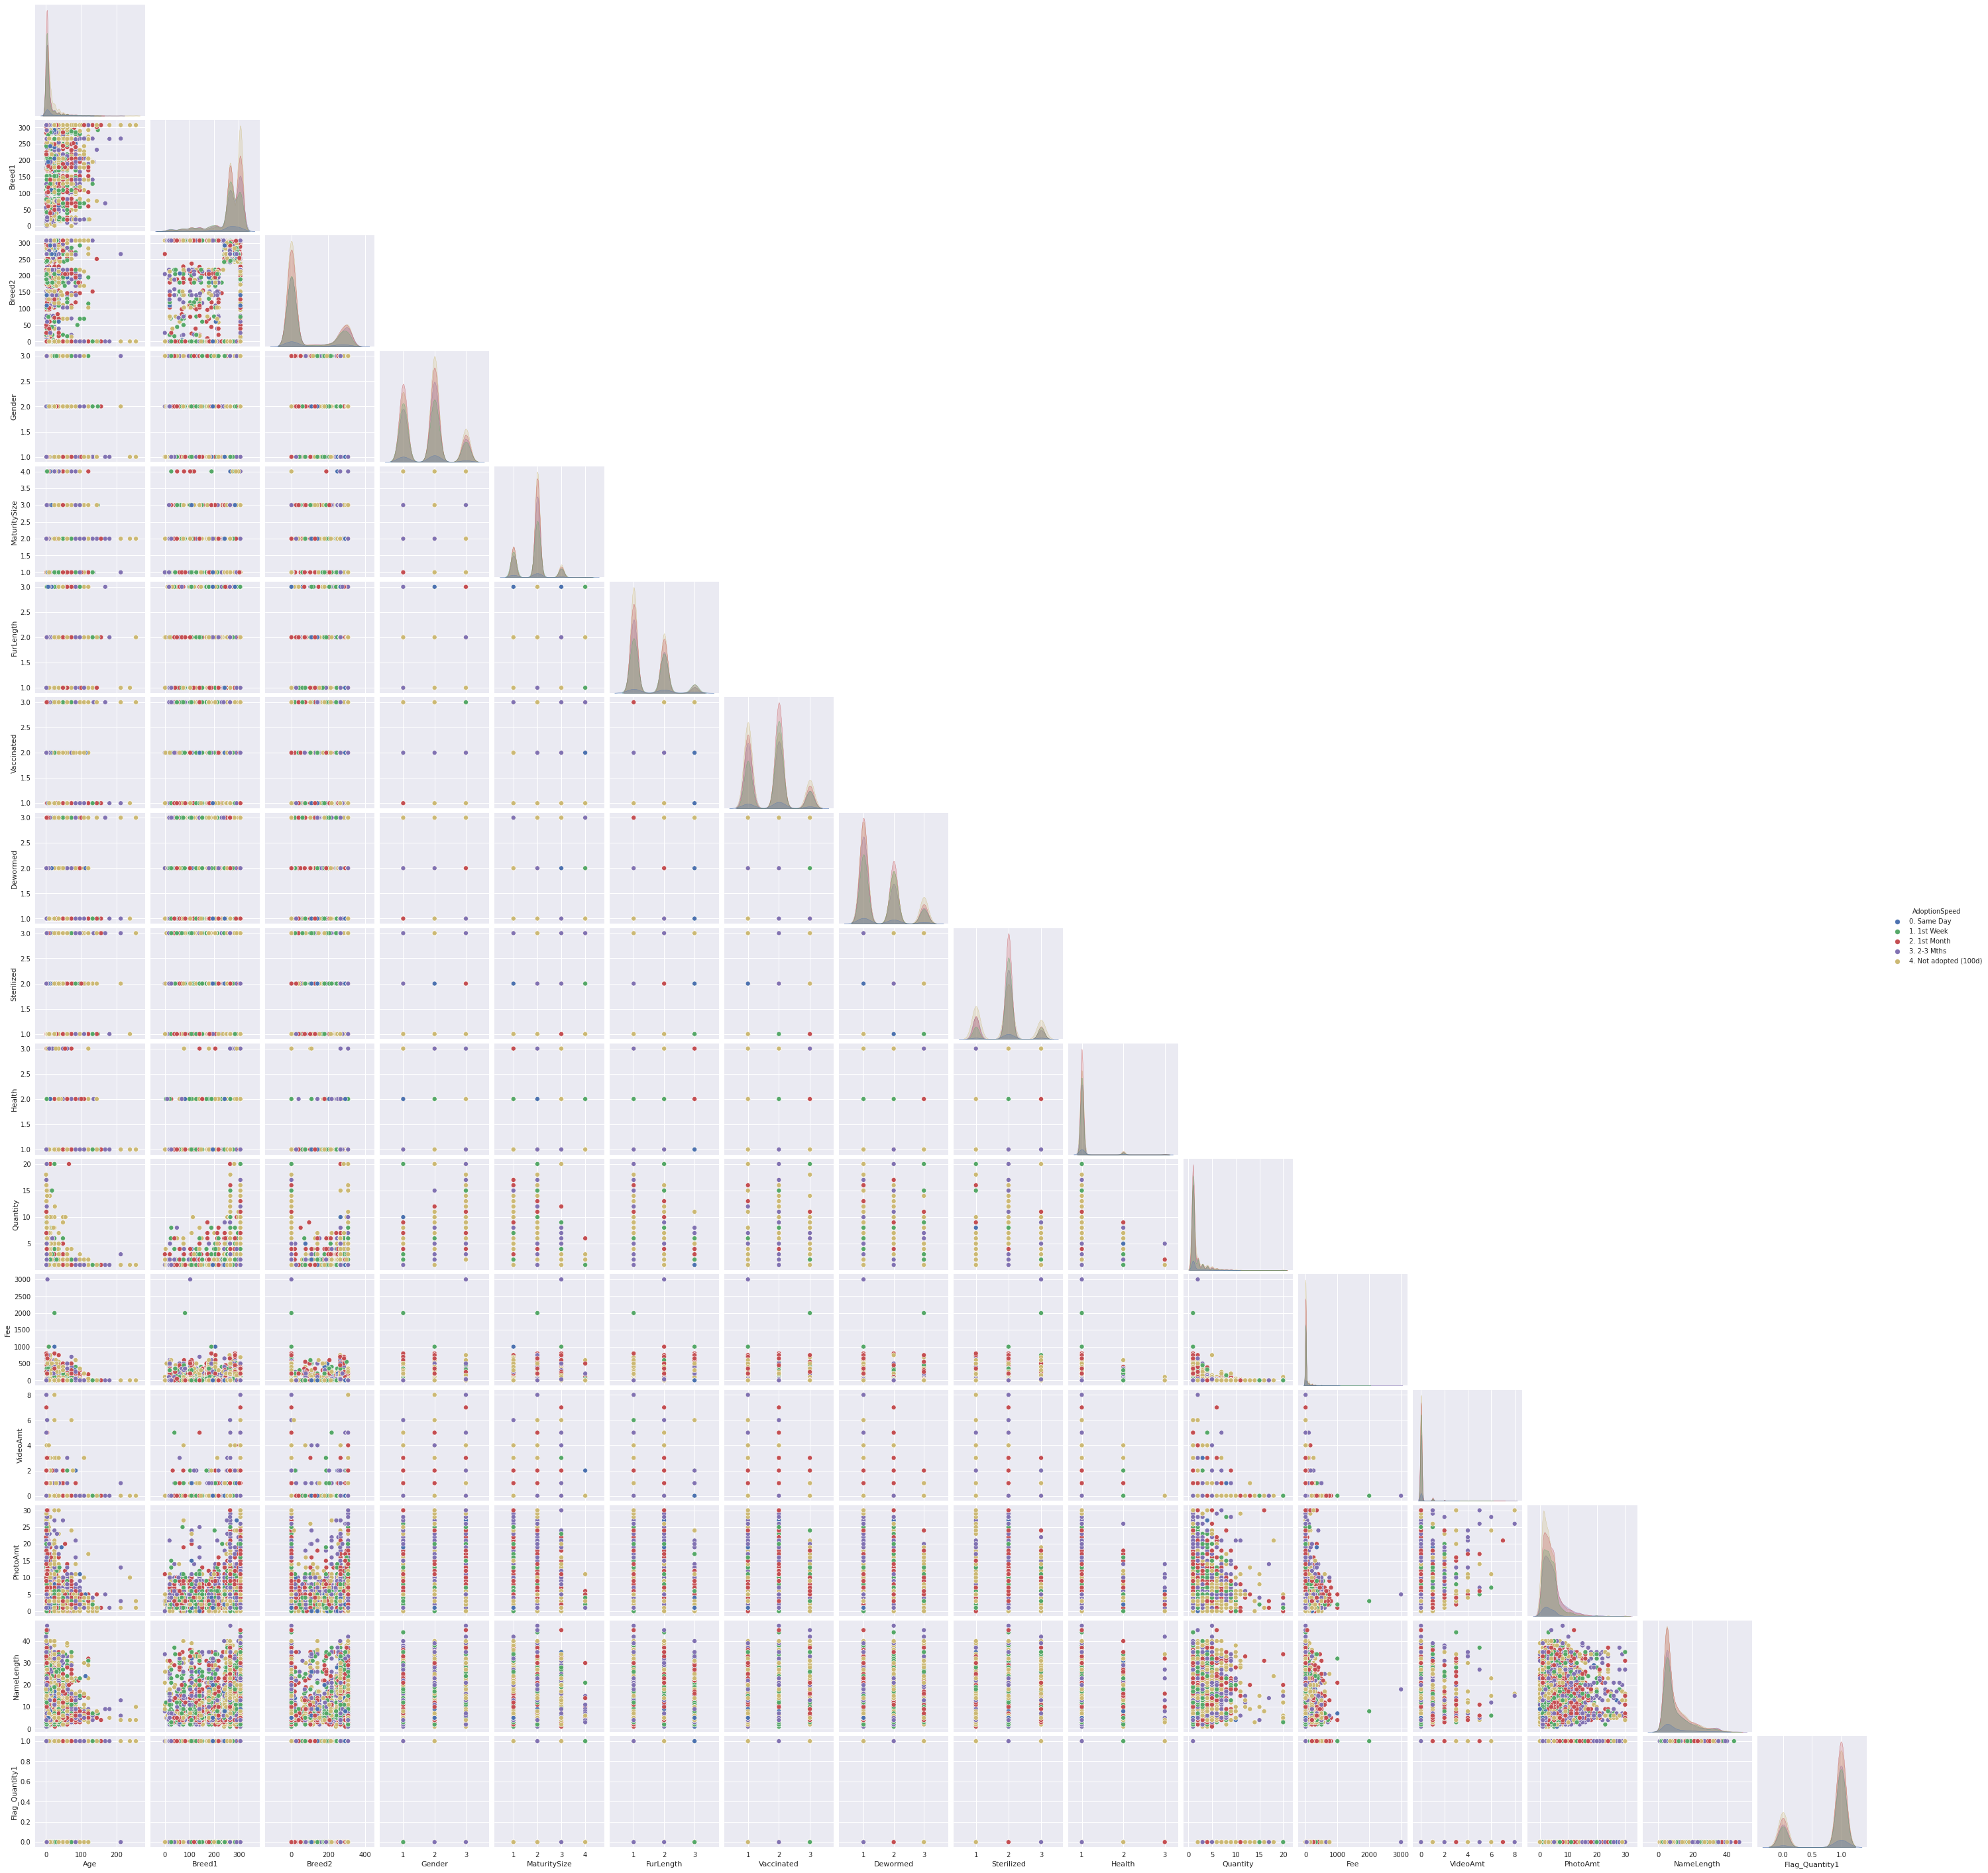

<Figure size 576x396 with 0 Axes>

In [53]:
cols_to_drop = ["Name", "Color1","Color2","Color3","RescuerID", "State", "Description", "PetID"]
pairplot_data = all_data.drop(columns=cols_to_drop)
sns.pairplot(pairplot_data,
             hue="AdoptionSpeed",
             corner=True)
plt.show()
plt.savefig("../outputs/sns-pairplot.png")

## AdoptionSpeed

Text(0.5, 1.0, 'Adoption Speed Class Distribution')

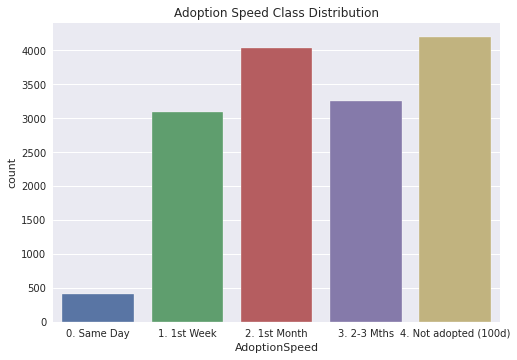

In [9]:
sns.countplot(x="AdoptionSpeed", data=all_data)
plt.title("Adoption Speed Class Distribution")

### Age

Text(0.5, 1.0, 'Distribution of Age across AdoptionSpeed')

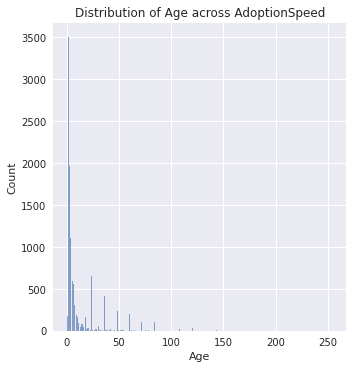

In [22]:
sns.displot(all_data, x="Age")
plt.title("Distribution of Age across AdoptionSpeed")
plt.savefig('../outputs/age_distribution.png', dpi=600)

Text(0.5, 1.0, 'Age against Adoption Speed')

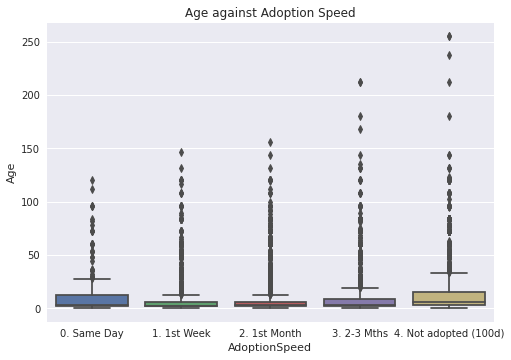

In [10]:
sns.boxplot(x="AdoptionSpeed", y="Age", data=all_data)
plt.title("Age against Adoption Speed")

Text(0.5, 1.0, 'Age against Cat/Dog')

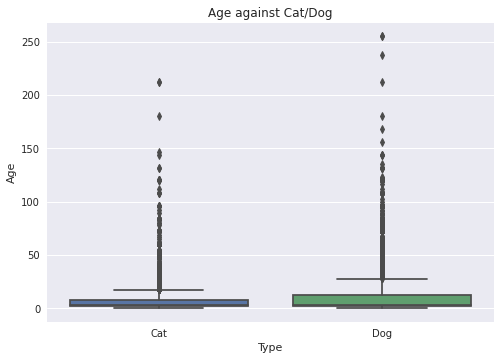

In [11]:
g = sns.boxplot(x="Type", y="Age", data=all_data)
plt.title("Age against Cat/Dog")

In [12]:
all_data[all_data["Age"] >= 20].to_csv("../outputs/elderly_pets.csv")

### Quantity

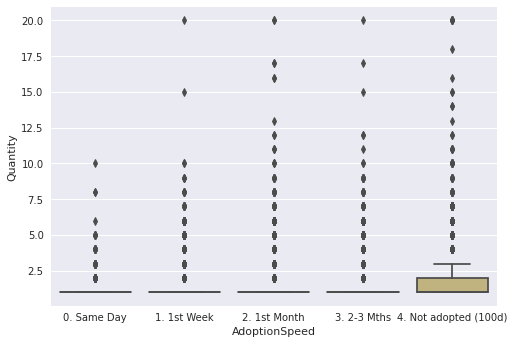

In [13]:
sns.boxplot(x="AdoptionSpeed", y="Quantity", data=all_data)
plt.show("Quantity against AdoptionSpeed")

Text(0.5, 0.98, 'Distribution of Quantity across AdoptionSpeed')

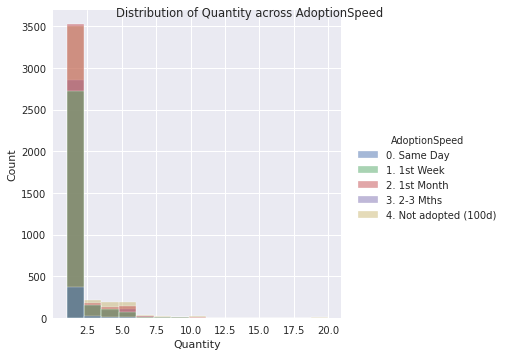

In [14]:
sns.displot(all_data, x="Quantity", hue="AdoptionSpeed")
plt.suptitle("Distribution of Quantity across AdoptionSpeed")

Looks like the distribution of quantity is similar across groups, but it's hard to say with all the outliers. What if we just compare 1 and 1+ listings?

In [50]:
all_data["Flag_Quantity1"] = (all_data["Quantity"] == 1)

<AxesSubplot:xlabel='Flag_Quantity1', ylabel='count'>

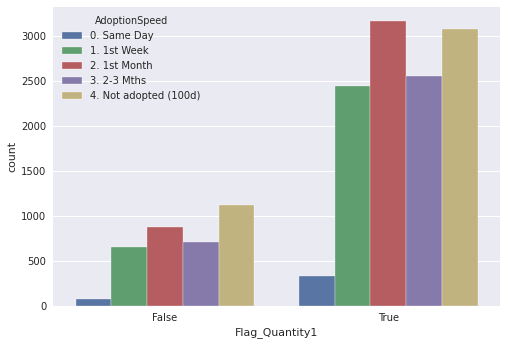

In [52]:
sns.countplot(x="Flag_Quantity1", hue="AdoptionSpeed", data=all_data)

Quantities don't seem to affect the adoptionspeed of a pet?

### Fee

Text(0.5, 1.0, 'Distribution of Fee across AdoptionSpeed')

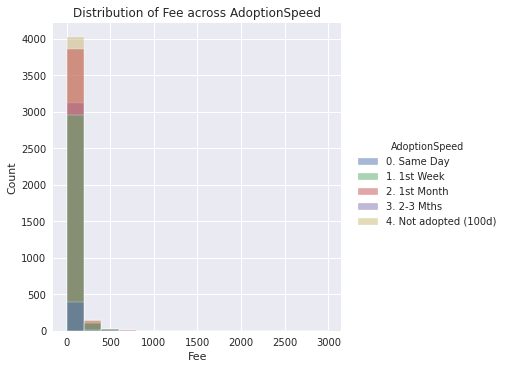

In [16]:
sns.displot(all_data, x="Fee", hue="AdoptionSpeed")
plt.title("Distribution of Fee across AdoptionSpeed")

<AxesSubplot:xlabel='AdoptionSpeed', ylabel='Fee'>

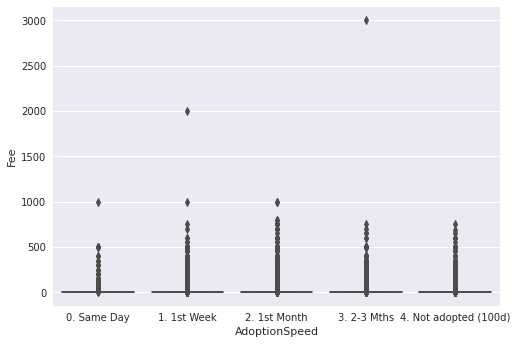

In [17]:
sns.boxplot(data=all_data, x="AdoptionSpeed", y="Fee")

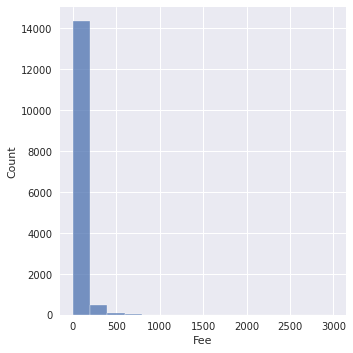

In [18]:
sns.displot(all_data, x="Fee")